# Introduction to the high accuracy positioning with open PPP/PPP-RTK services

## Introduction to CSSRlib

*CSSRLIB* is a open toolkit in Python for high accuracy GNSS positioning. It supports SSR (State-Space Representation) based potitioning such as PPP (Precise Point Positioning) or PPP-RTK (Realtime Kinematic), and also supports RTK. The goal of the CSSRlib toolkit is to provide an easy-to-understand open implementation to learn PPP/PPP-RTK positioning provided by satellite-based open PPP/PPP-RTK services such as QZSS CLAS, Galileo HAS, and BeiDou 3 PPP. It also supports ground based open service by IGS. The code is based on RTKlib.

It supports the following open format:

- The observation data and the ephemeis in RINEX
- The PPP/PPP-RTK correction data in RTCM SSR, IGS SSR, Compact SSR, ...
- The precise orbit/clock data in SP3 format.


## Installation

You can install CSSRlib using pip or clone the repo from Github.



In [2]:
# %pip install cssrlib   # install released version

!git clone -b new_sig https://github.com/hirokawa/cssrlib.git  # new_sig branch for now
!mv cssrlib/src/cssrlib/*.* cssrlib

Cloning into 'cssrlib'...
remote: Enumerating objects: 2091, done.
remote: Counting objects: 100% (1011/1011), done.
remote: Compressing objects: 100% (306/306), done.
remote: Total 2091 (delta 679), reused 834 (delta 576), pack-reused 1080
Receiving objects: 100% (2091/2091), 11.09 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (1293/1293), done.


additional python packages are required as prerequisites and can be installed via the following commands.  Note that the cartopy package is not available in Windows but is used only for plotting the results.

In [3]:
# %pip install notebook numpy matplotlib  # Already installed in Colab but may be needed if running locally

%pip install bitstruct galois
%pip install cartopy                      # Comment this line out if running in Windows

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 12.0 MB/s eta 0:00:00
  Created wheel for bitstruct: filename=bitstruct-8.17.0-cp310-cp310-linux_x86_64.whl size=64215 sha256=05efe4ef994bdfa4305b109b4ec99087bcdf7e108e2adc170d84e52a3bdfddd7
  Stored in directory: /root/.cache/pip/wheels/9e/65/1c/1d738fbe145371947d129a90e926ccd0abeb07e70b9fa5f052
Successfully built bitstruct
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.5 MB/s eta 0:00:00


## Structure of CSSRlib


CSSRlib consits of multiple python files/modules as follows:

- Contructor (`__init__`): initialize the variables used in CSSRlib.
- `gnss`: Common subroutines and classes used in CSSRlib.
- `ephemeris`: calculate the position of satellite using ephemeris.
- `peph`: calculate the position of satellite using precise ephemeris in SP3 format．
- `tlesim`: calculate the position of satellite using TLE.
- `plot`: subroutines to visualize.

- `rinex`: parse RINEX obs/nav file.
- `cssrlib`: parse PPP/PPP-RTK correction messages in Compact SSR (CSSR) format.
- `ppp_has`: parse PPP correction messages in Galileo HAS format.
- `ppp_bds`: parse PPP correction messages in BDS-3 PPP format.

- `pntpos`: standalone positioning
- `rtk`: RTK positioning
- `ppprtk`: PPP-RTK positioning
- `ppp`: functions for PPP positioning
- `pppigs`: standard PPP positioning


## Load Sample Data and Test Scripts from Github

Sample data and test scripts are provided in a separate Github respository

In [4]:
!git clone https://github.com/hirokawa/cssrlib-data.git

Cloning into 'cssrlib-data'...
remote: Enumerating objects: 930, done.
remote: Counting objects: 100% (361/361), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 930 (delta 224), reused 265 (delta 205), pack-reused 569
Receiving objects: 100% (930/930), 116.99 MiB | 8.39 MiB/s, done.
Resolving deltas: 100% (602/602), done.
Updating files: 100% (87/87), done.



## Examples

This tutorial provides examples to show the basic features of CSSRlib for Standalone, RTK, PPP-RTK, and PPP positioning using correction data from open PPP/PPP-RTK services. The following examples are included:

- Visualizing orbit of QZSS satellite
- Showing skyplot
- Standalone positioning
- RTK positioning
- PPP-RTK positioning (QZSS-CLAS)
- PPP positioning (BeiDou)
- PPP positioning (Galileo HAS)
- PPP positioning (IGS)
- PPP positioning (MADOCA)

Click on the arrows in the left margin to open or close an example

## Example 1: Visualizing Orbit of QZSS Satellite

In the first example, we will introduce the basic feature of CSSRlib to calculate and visalize a satellite orbit.

At first, we will load the required Python modules such as NumPy, Matplotlib, Cartopy. Then we will load modules from CSSRlib.

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from cssrlib.rinex import rnxdec
from cssrlib.gnss import Nav, epoch2time, prn2sat, uGNSS, sat2prn,\
    timeadd, ecef2pos
from cssrlib.ephemeris import findeph, eph2pos

In CSSRlib, the epoch is defined as Python Class `gtime_t` as in RTKlib. The snipet defines epoch "19/3/2021 0:00:00", shows the internal variable of `gtime_t`.

In [6]:
t0 = epoch2time([2021, 3, 19, 0, 0, 0]) # year, month, day, hour, minute, sec
t0.time,t0.sec

(1616112000, 0)

Then, the ephemeris in RINEX format is loaded using RINEX decoder in CSSRlib.

In [7]:
dec = rnxdec()
nav = dec.decode_nav( 'cssrlib-data/data/30340780.21q', Nav()) # load RINEX navigation file

The satellite is identified by the system (GPS, Galileo, QZS, ...) and PRN number, it should be converted into the internal satellite number using `prn2sat`. The snippet shows the satellite number for QZSS with PRN 194 (QZS-2):

In [8]:
sat = prn2sat(uGNSS.QZS, 194)
sat

70

The orbit position of a GNSS satellite can be calculated using ephemeris defined in the RINEX navigation file. The valid ephemeris for a specific epoch can be searched for using `findeph`, position/velocity in ECEF and clock bias are calculated by `eph2pos`. The position in geodetic cordinates can be calculated by `ecef2pos`:

In [9]:
t = t0
eph = findeph(nav.eph, t, sat)
rs, vs, dts = eph2pos(t, eph, True)
print('rs=',rs, 'vs=', vs,'dts=', dts)
pos = ecef2pos(rs)
print('pos=',pos)

rs= [-27695465.67390223  25576355.5431149   23733383.2869802 ] vs= [ 618.82498925 -271.15881898 1281.49729409] dts= 3.4869334074196084e-06
pos= [5.62300943e-01 2.39595272e+00 3.81752334e+07]


The orbit of QZS-2 in 1 days (24 hours) is calculated and plotted using Cartopy:

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


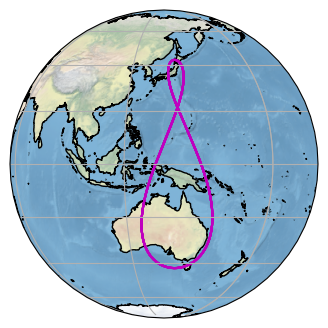

In [10]:
lon0 = 135
plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon0,
                                           central_latitude=0))
ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()

n = 24*3600//300
pos = np.zeros((n, 3))
r2d = 180/np.pi

for k in range(uGNSS.MAXSAT):
    sat = k+1
    sys, prn = sat2prn(sat)
    if sys != uGNSS.QZS:  # skip non QZSS
        continue
    for i in range(n):
        t = timeadd(t0, i*300)
        if eph is None:
            continue
        rs, dts = eph2pos(t, eph)
        pos[i, :] = ecef2pos(rs)

    plt.plot(pos[:, 1]*r2d, pos[:, 0]*r2d, 'm-', transform=ccrs.Geodetic())
plt.show()

## Example 2: Showing Skyplot

For the visualization of measurement, CSSRlib supports the skyplot of satellte orbit path at specific location. At first, the required modules are loaded.

In [11]:
import numpy as np
from cssrlib.gnss import Nav, ecef2pos, geodist, satazel, timediff, uGNSS, rSigRnx
from cssrlib.ephemeris import findeph, eph2pos
from cssrlib.plot import skyplot, plot_elv
from cssrlib.rinex import rnxdec

Then an instance of a RINEX decoder is generated. In this example, the observation and navigation files measured by a Septentrio Mosaic-X5 receiver are used.  We also need to specify which satellite signals will be used.

In [12]:
navfile = 'cssrlib-data/data/SEPT078M.21P'
obsfile = 'cssrlib-data/data/SEPT078M.21O'

dec = rnxdec()
nav = dec.decode_nav(navfile,Nav())

sigs = [rSigRnx("GC1C"), rSigRnx("EC1C"), rSigRnx("JC1C")]
dec.setSignals(sigs)


Next, the orbit of tracked satellites is calculated for 15 minutes of epoch.

In [13]:
nep = 15*60  # 15 minutes
elv = np.ones((nep, uGNSS.MAXSAT))*np.nan
azm = np.ones((nep, uGNSS.MAXSAT))*np.nan
t = np.zeros(nep)*np.nan

if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    pos = ecef2pos(rr)
    for ne in range(nep):
        print('\repoch=%d/%d' % (ne, nep), end='')
        obs = dec.decode_obs()
        if ne == 0:
            t0 = obs.t
        t[ne] = timediff(obs.t, t0)
        for k, sat in enumerate(obs.sat):
            eph = findeph(nav.eph, obs.t, sat)
            if eph is None:
                continue
            rs, dts = eph2pos(obs.t, eph)
            r, e = geodist(rs, rr)
            azm[ne, sat-1], elv[ne, sat-1] = satazel(pos, e)
    dec.fobs.close()

epoch=899/900

The elevation and azimuth angles of each satellite are recorded, and the skyplot is generated as below:

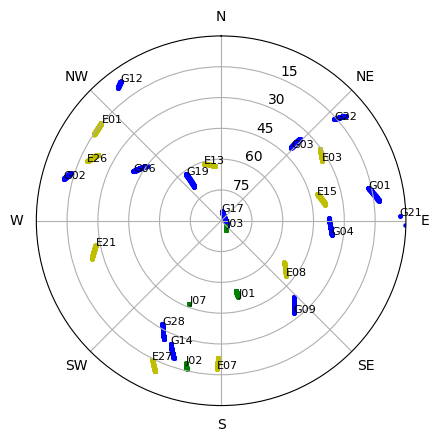

In [14]:
#plot_elv(t, elv)
nsat = skyplot(azm, elv)

## Example 3: Standalone positioning

This section introduces the standalone GNSS positioning using RINEX observation.  First, the required Python modules are loaded.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from cssrlib.rinex import rnxdec
from cssrlib.gnss import ecef2pos, timediff, dops, ecef2enu, rSigRnx
from cssrlib.pntpos import stdinit, pntpos

The rover position is defined for reference.

In [16]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = ecef2pos(xyz_ref)

RINEX navigation and observation files are defined, an instance of RINEX decoder is generated, and satellite signals are specified.

In [17]:
navfile = 'cssrlib-data/data/SEPT078M.21P'
obsfile = 'cssrlib-data/data/SEPT078M.21O'
dec = rnxdec()
nav = dec.decode_nav(navfile, stdinit())

sigs = [rSigRnx("GC1C"), rSigRnx("EC1C"), rSigRnx("JC1C")]
dec.setSignals(sigs)

The variables for position, DOPs, number of satellite are defined for 6 minutes epoch.

In [18]:
nep = 6*60  # 6 minutes
t = np.zeros(nep)
enu = np.zeros((nep, 3))
sol = np.zeros((nep, nav.nx))
dop = np.zeros((nep, 4))
nsat = np.zeros(nep, dtype=int)

The standalone GNSS positioning by `pntpos()` is conducted for 6 minutes.

In [19]:
if dec.decode_obsh(obsfile) >= 0:
    nav.x[0:3] = dec.pos
    for ne in range(nep):
        print('\repoch=%d/%d' % (ne, nep), end='')
        obs = dec.decode_obs()
        if ne == 0:
            t0 = nav.t = obs.t
        t[ne] = timediff(obs.t, t0)
        nav, az, el = pntpos(obs, nav)
        sol[ne, :] = nav.x
        dop[ne, :] = dops(az, el)
        enu[ne, :] = ecef2enu(pos_ref, sol[ne, 0:3]-xyz_ref)
        nsat[ne] = len(el)
    dec.fobs.close()

epoch=359/360

The ENU position relative to the reference position is plotted.

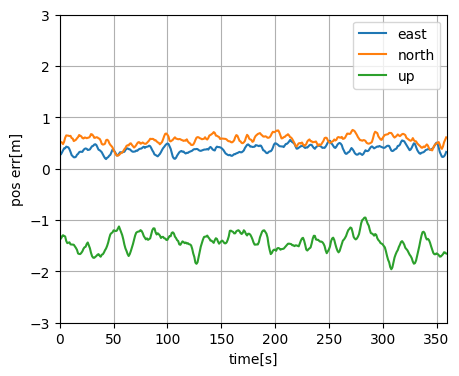

In [20]:
def plt_enu(t, enu, dmax=0.4):
    plt.figure(figsize=(5,4))
    plt.plot(t, enu)
    plt.ylabel('pos err[m]')
    plt.xlabel('time[s]')
    plt.legend(['east', 'north', 'up'])
    plt.grid()
    plt.axis([0, nep, -dmax, dmax])
    plt.show()

plt_enu(t, enu, 3)

To measure the geomtry for positioning, DOPs (PDOP, HDOP, VDOP) are plotted:

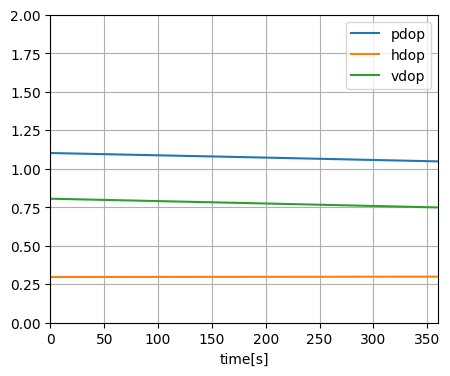

In [21]:
def plt_dop(t, dop):
    nep = len(t)
    plt.figure(figsize=(5,4))
    plt.plot(t, dop)
    plt.legend(['pdop', 'hdop', 'vdop'])
    plt.grid()
    plt.axis([0, nep, 0, 2])
    plt.xlabel('time[s]')
    plt.show()

plt_dop(t,dop[:,1:])

## Example 4: RTK positioning

This section describes RTK positioning.  First, the required Python modules are loaded.

In [22]:
import matplotlib.pyplot as plt
import numpy as np

import cssrlib.rinex as rn
import cssrlib.gnss as gn
from cssrlib.gnss import rSigRnx
from cssrlib.peph import atxdec, searchpcv
from cssrlib.rtk import rtkinit, relpos

The reference position of rover is defined for evaulation.

In [23]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = gn.ecef2pos(xyz_ref)

Specify the satellite signals to be processed for base and rover

In [24]:
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]

sigsb = [rSigRnx("GC1C"), rSigRnx("GC2W"),
         rSigRnx("EC1X"), rSigRnx("EC5X"),
         rSigRnx("JC1X"), rSigRnx("JC2X"),
         rSigRnx("GL1C"), rSigRnx("GL2W"),
         rSigRnx("EL1X"), rSigRnx("EL5X"),
         rSigRnx("JL1X"), rSigRnx("JL2X"),
         rSigRnx("GS1C"), rSigRnx("GS2W"),
         rSigRnx("ES1X"), rSigRnx("ES5X"),
         rSigRnx("JS1X"), rSigRnx("JS2X")]

The measurement and ephemeris data on rover (Septentrio Mosaic-X5) are loaded.

In [25]:
bdir = 'cssrlib-data/data/'
navfile = bdir+'SEPT078M.21P'
obsfile = bdir+'SEPT078M.21O'

# rover
dec = rn.rnxdec()
dec.setSignals(sigs)
nav = gn.Nav()
dec.decode_nav(navfile, nav)
dec.decode_obsh(obsfile)

0

For RTK positioning, the observation file for the base station also need to be specified. The position of the base station is also defined.

In [26]:
# base station
basefile = bdir+'3034078M.21O'
nav.rb = [-3959400.631, 3385704.533, 3667523.111]
decb = rn.rnxdec()
decb.setSignals(sigsb)
decb.decode_obsh(basefile)

0

Load antenna data for satellites and receivers

In [27]:
atxfile = bdir+'igs14.atx'
atx = atxdec()
atx.readpcv(atxfile)

if 'UNKNOWN' in dec.ant or dec.ant.strip() == "":
    dec.ant = "{:16s}{:4s}".format("JAVRINGANT_DM", "SCIS")
if 'UNKNOWN' in decb.ant or decb.ant.strip() == "":
    decb.ant = "{:16s}{:4s}".format("TRM59800.80", "NONE")

# Set PCO/PCV information
nav.rcv_ant = searchpcv(atx.pcvr, dec.ant,  dec.ts)
nav.rcv_ant_b = searchpcv(atx.pcvr, decb.ant,  dec.ts)
if nav.rcv_ant is None:
    print("ERROR: missing antenna type <{}> in ANTEX file!".format(dec.ant))
    sys.exit(-1)
nav.rcv_ant_b = searchpcv(atx.pcvr, decb.ant,  dec.ts)
if nav.rcv_ant_b is None:
    print("ERROR: missing antenna type <{}> in ANTEX file!".format(decb.ant))
    sys.exit(-1)

The variables for position are initialized. RTK parameters are also initialized.

In [29]:
nep = 60
t = np.zeros(nep)
enu = np.zeros((nep, 3))
smode = np.zeros(nep, dtype=int)

rtkinit(nav, dec.pos)
rr = dec.pos

RTK positioning is conducted for 60 seconds (epochs) using `relpos()`.

In [30]:
for ne in range(nep):
    obs, obsb = rn.sync_obs(dec, decb)
    print('\repoch=%d/%d' % (ne, nep), end='')
    if ne == 0:
        t0 = nav.t = obs.t
    relpos(nav, obs, obsb)
    t[ne] = gn.timediff(nav.t, t0)
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode

dec.fobs.close()
decb.fobs.close()

epoch=59/60

The position relative to the reference position is plotted.

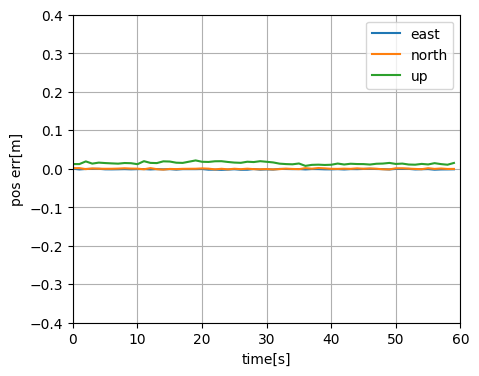

In [31]:
plt_enu(t, enu)

## Example 5: PPP-RTK positioning (QZSS CLAS)

This section shows PPP-RTK positioning using QZSS CLAS.  First, the required Python modules are loaded.

In [43]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

import cssrlib.gnss as gn
from cssrlib.cssrlib import cssr
from cssrlib.gnss import ecef2pos, Nav, time2gpst, timediff, time2str, epoch2time
from cssrlib.gnss import rSigRnx, sys2str
from cssrlib.peph import atxdec, searchpcv
from cssrlib.ppprtk import rtkinit, ppprtkpos
from cssrlib.rinex import rnxdec
from sys import stdout

Then, RINEX observation and navigation files are defined and the antenna file.

In [33]:
navfile = 'cssrlib-data/data/SEPT078M.21P'
obsfile = 'cssrlib-data/data/SEPT078M.21O'
atxfile = 'cssrlib-data/data/igs14.atx'

nav = Nav()
nav = dec.decode_nav(navfile, nav)

atx = atxdec()
atx.readpcv(atxfile)

For the reference, the rover position based on GSI F5 solution is defined.

In [34]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]  # based on GSI F5 solution
pos_ref = ecef2pos(xyz_ref)

QZSS CLAS correction messages are encoded in Compact SSR format. In this example, the recorded L6 data ( doy 078 in 2021, session M) is used. The grid position of QZSS CLAS defined in IS-QZSS-L6 is also loaded.

In [35]:
l6file = 'cssrlib-data/data/2021078M.l6'
griddef = 'cssrlib-data/data/clas_grid.def'
cs = cssr()
cs.monlevel = 1
cs.week = 2149
cs.read_griddef(griddef)

Specify signals to be processed

In [36]:
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]

rnx = rnxdec()
rnx.setSignals(sigs)

Set start time, runtime to 3 minutes and initialize variables

In [37]:
ep = [2021, 3, 19, 12, 0, 0]
time = epoch2time(ep)
nep = 3*60  # 3 minutes, increase this for longer run

t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
smode = np.zeros(nep, dtype=int)

Initialize position and antenna PCO/PCVs

In [39]:
if rnx.decode_obsh(obsfile) >= 0:
    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rtkinit(nav, rnx.pos, 'ppprtk.log')

    if 'UNKNOWN' in rnx.ant or rnx.ant.strip() == '':
        rnx.ant = "{:16s}{:4s}".format("JAVRINGANT_DM", "SCIS")
    if 'UNKNOWN' in rnx.ant or rnx.ant.strip() == "":
        nav.fout.write("ERROR: missing antenna type in RINEX OBS header!\n")

    # Set PCO/PCV information
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)
    if nav.rcv_ant is None:
        nav.fout.write("ERROR: missing antenna type <{}> in ANTEX file!\n"
                       .format(rnx.ant))

Print available signals and selected signals

In [40]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
    txt = "{:7s} {}".format(sys2str(sys),
            ' '.join([sig.str() for sig in sigs.values()]))
    print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
    txt = "{:7s} ".format(sys2str(sys))
    for _, sigs in tmp.items():
        txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
    print(txt)


Available signals
GPS     C1C L1C S1C C1W S1W C2W L2W S2W C2L L2L S2L C5Q L5Q S5Q
GALILEO C1C L1C S1C C5Q L5Q S5Q C7Q L7Q S7Q C8Q L8Q S8Q
QZSS    C1C L1C S1C C2L L2L S2L C5Q L5Q S5Q

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 
QZSS    C1C C2L L1C L2L S1C S2L 


Get grid location and open L6 file

In [41]:
pos = ecef2pos(rnx.pos)
inet = cs.find_grid_index(pos)

fc = open(l6file, 'rb')

Run PPP-RTK positioning using `ppprtkpos()` for 3 minutes. QZSS L6 messages are encoded in sub-frames (5 second per sub-frame), for the simple implementation, the recorded data is decoded in every 5 seconds.

In [44]:
# Skip epoch until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

for ne in range(nep):
    week, tow = time2gpst(obs.t)
    #print('\repoch=%d/%d' % (ne, nep), end='')

    cs.decode_l6msg(fc.read(250), 0)
    if cs.fcnt == 5:  # end of sub-frame
        cs.week = week
        cs.decode_cssr(cs.buff, 0)

    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        cs.time = obs.t
        nav.time_p = t0

    cstat = cs.chk_stat()
    if cstat:
        ppprtkpos(nav, obs, cs)

    t[ne] = timediff(nav.t, t0) / 60

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:9.3f} {:9.3f} {:9.3f}, mode {:1d}'
                .format(time2str(obs.t),
                        enu[ne, 0], enu[ne, 1], enu[ne, 2],
                        smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

fc.close()
rnx.fobs.close()


 2021-03-19 12:03:00 ENU    -0.004    -0.005     0.029, mode 4

RTK mode status (4: fix, 5: float, 0: no-solution) is defined for plotting.

In [45]:
idx4 = np.where(smode == 4)[0]
idx5 = np.where(smode == 5)[0]
idx0 = np.where(smode == 0)[0]

The relative position with reference position is plotted. After receiving QZSS CLAS correction message within 30 seconds, the position is instatenously fixed, it shows RTK-like performance.

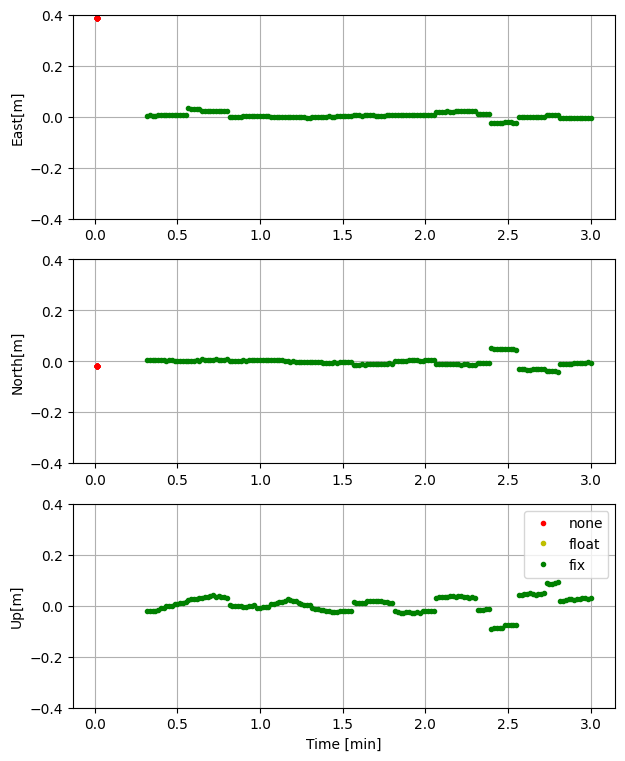

In [48]:
ylim = 0.4
fig = plt.figure(figsize=[7, 9])
lbl_t = ['East[m]', 'North[m]', 'Up[m]']
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.', label='none')
    plt.plot(t[idx5], enu[idx5, k], 'y.', label='float')
    plt.plot(t[idx4], enu[idx4, k], 'g.', label='fix')

    if k == 2:
        plt.xlabel('Time [min]')
        plt.legend()
    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.ylim([-ylim, ylim])
plt.show()

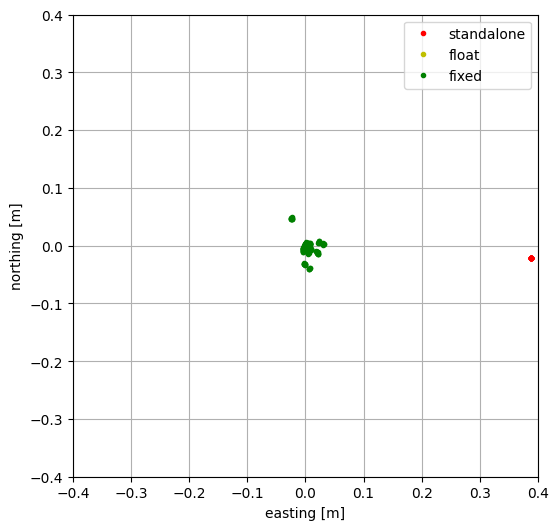

In [49]:
fig = plt.figure(figsize=[6,6])
plt.plot(enu[idx0, 0],enu[idx0, 1], 'r.', label='standalone')
plt.plot(enu[idx5, 0],enu[idx5, 1], 'y.', label='float')
plt.plot(enu[idx4, 0],enu[idx4, 1], 'g.', label='fixed')
plt.xlabel('easting [m]')
plt.ylabel('northing [m]')
plt.axis([-ylim,ylim,-ylim,ylim])
plt.grid()
plt.legend()
plt.show()


## Example 6: PPP positioning (IGS)

This section shows PPP positioning using IGS. First, the required Python modules are loaded.

In [116]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from sys import stdout

import cssrlib.gnss as gn
from cssrlib.gnss import ecef2pos, Nav
from cssrlib.gnss import time2doy, time2str, timediff, epoch2time
from cssrlib.gnss import rSigRnx
from cssrlib.gnss import sys2str
from cssrlib.peph import atxdec, searchpcv
from cssrlib.peph import peph, biasdec
from cssrlib.pppigs import rtkinit, ppppos, IT
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [125]:
# Start epoch, number of epochs
ep = [2023, 7, 8, 4, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

navfile = 'cssrlib-data/data/SEPT1890.23P'
obsfile = 'cssrlib-data/data/SEPT1890.23O'

# Specify PPP correction files
orbfile = 'cssrlib-data/data/COD0MGXFIN_20231890000_01D_05M_ORB.SP3'
clkfile = 'cssrlib-data/data/COD0MGXFIN_20231890000_01D_30S_CLK.CLK'
bsxfile = 'cssrlib-data/data/COD0MGXFIN_20231890000_01D_01D_OSB.BIA'

# Set user reference position
xyz_ref = [-3962108.7063, 3381309.5703, 3668678.6690]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q")]

atxfile = 'cssrlib-data/data/I20.ATX'

Load and parse the input data

In [126]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load precise orbits and clock offsets
nav = orb.parse_sp3(orbfile, nav)
nav = rnx.decode_clk(clkfile, nav)

# Load code and phase biases from Bias-SINEX
bsx = biasdec()
bsx.parse(bsxfile)

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rtkinit(nav, rnx.pos, 'ppp-igs.log')

    # change default settings
    nav.elmin = np.deg2rad(5.0)  # min sat elevation
    nav.thresar = 2.0            # ambiguity resolution threshold

    if 'UNKNOWN' in rnx.ant or rnx.ant.strip() == '':
        rnx.ant = "{:16s}{:4s}".format("JAVRINGANT_DM", "JVDM")

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available and selected satellite signals

In [127]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GALILEO C1C L1C D1C S1C C6C L6C D6C S6C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q
SBAS    C1C L1C D1C S1C C5I L5I D5I S5I
GLONASS C1C L1C D1C S1C C2P L2P D2P S2P C2C L2C D2C S2C C3Q L3Q D3Q S3Q
BEIDOU  C1P L1P D1P S1P C5P L5P D5P S5P C2I L2I D2I S2I C7I L7I D7I S7I C6I L6I D6I S6I C7D L7D D7D S7D
QZSS    C1C L1C D1C S1C C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 


Process data for 5 minutes (ok to abort before finished)

In [128]:
nep = 5 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)

    # Call PPP module with IGS products
    ppppos(nav, obs, orb=orb, bsx=bsx)

    # Save output
    t[ne] = timediff(nav.t, t0) / 60

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[IT(nav.na)] if nav.smode == 4 else nav.x[IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()


 2023-07-08 04:05:00 ENU   0.310   0.119  -0.613, 2D  0.332, mode 5

Plot results

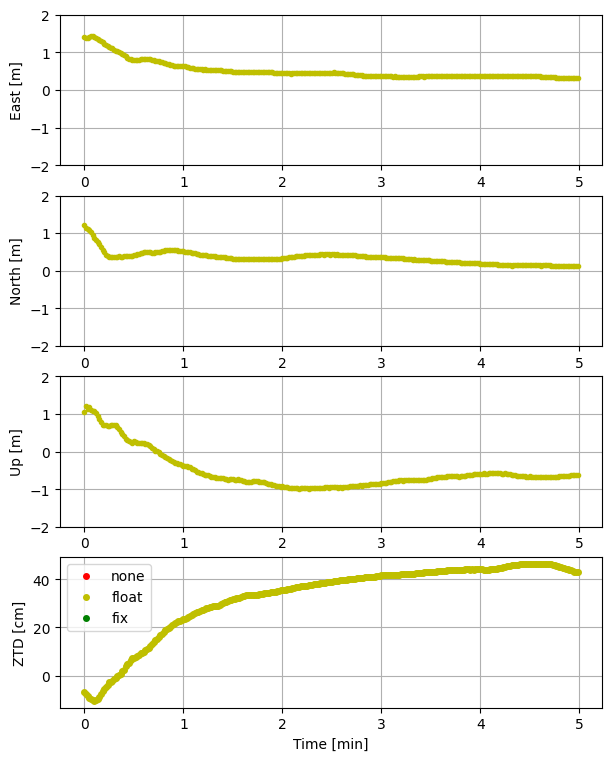

In [129]:
ylim = 2.0

idx4 = np.where(smode == 4)[0]   # fix
idx5 = np.where(smode == 5)[0]   # float
idx0 = np.where(smode == 0)[0]   # none

fig = plt.figure(figsize=[7, 9])
fig.set_rasterized(True)


lbl_t = ['East [m]', 'North [m]', 'Up [m]']

for k in range(3):
    plt.subplot(4, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.')
    plt.plot(t[idx5], enu[idx5, k], 'y.')
    plt.plot(t[idx4], enu[idx4, k], 'g.')

    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.ylim([-ylim, ylim])

plt.subplot(4, 1, 4)
plt.plot(t[idx0], ztd[idx0]*1e2, 'r.', markersize=8, label='none')
plt.plot(t[idx5], ztd[idx5]*1e2, 'y.', markersize=8, label='float')
plt.plot(t[idx4], ztd[idx4]*1e2, 'g.', markersize=8, label='fix')

plt.ylabel('ZTD [cm]')
plt.grid()
plt.xlabel('Time [min]')
plt.legend()


## Example 7: PPP positioning (BeiDou)

This section shows PPP-RTK positioning using BeiDou.  First, the required Python modules are loaded.

In [130]:
from binascii import unhexlify
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from sys import stdout

import cssrlib.gnss as gn
from cssrlib.gnss import ecef2pos, Nav
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.gnss import rSigRnx
from cssrlib.gnss import sys2str
from cssrlib.peph import atxdec, searchpcv
from cssrlib.peph import peph
from cssrlib.cssr_bds import cssr_bds
from cssrlib.pppssr import rtkinit, ppppos, IT
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [137]:
ep = [2023, 8, 11, 21, 0, 0] # start epoch

navfile = 'cssrlib-data/data/doy223/BRD400DLR_S_20232230000_01D_MN.rnx'
obsfile = 'cssrlib-data/data/doy223/SEPT223Y.23O'  # PolaRX5
file_bds = 'cssrlib-data/data/doy223/223v_bdsb2b.txt'
prn_ref = 59  # satellite PRN to receive BDS PPP collection

dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S124')]

xyz_ref = [-3962108.6726, 3381309.4719, 3668678.6264]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("CC1P"), rSigRnx("CC5P"),
        rSigRnx("CL1P"), rSigRnx("CL5P"),
        rSigRnx("CS1P"), rSigRnx("CS5P")]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))
if time > epoch2time([2022, 11, 27, 0, 0, 0]):
    atxfile = 'cssrlib-data/data/igs20.atx'
else:
    atxfile = 'cssrlib-data/data/igs14.atx'

Load and parse the input data

In [138]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_bds, dtype=dtype)

cs = cssr_bds()
cs.monlevel = 0

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rtkinit(nav, rnx.pos, 'pppbds.log')

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available and selected satellite signals

In [133]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C1W S1W C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L
GALILEO C1C L1C D1C S1C C6C L6C D6C S6C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q
SBAS    C1C L1C D1C S1C C5I L5I D5I S5I
GLONASS C1C L1C D1C S1C C1P L1P D1P S1P C2P L2P D2P S2P C2C L2C D2C S2C C3Q L3Q D3Q S3Q
BEIDOU  C1P L1P D1P S1P C5P L5P D5P S5P C2I L2I D2I S2I C7I L7I D7I S7I C6I L6I D6I S6I C7D L7D D7D S7D
QZSS    C1C L1C D1C S1C C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L C1Z L1Z D1Z S1Z C5P L5P D5P S5P
IRNSS   C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
BEIDOU  C1P C5P L1P L5P S1P S5P 


Process data for 10 minutes (ok to abort before finished)

In [139]:
nep = 10 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 86400 * 86400

    # Set intial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time // 30 * 30
        nav.time_p = t0

    vi = v[(v['tow'] == tow) & (v['prn'] == prn_ref)]
    if len(vi) > 0:
        buff = unhexlify(vi['nav'][0])
        cs.decode_cssr(buff, 0)

    # Call PPP module with BDS-PPP corrections
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppppos(nav, obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 60

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[IT(nav.na)] if nav.smode == 4 else nav.x[IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()

 2023-08-11 21:00:13 ENU  -0.370   0.113   1.232, 2D  0.387, mode 0 too few satellites < 6: nsat=5
 2023-08-11 21:10:00 ENU   0.211  -0.370   0.523, 2D  0.425, mode 5

Plot results

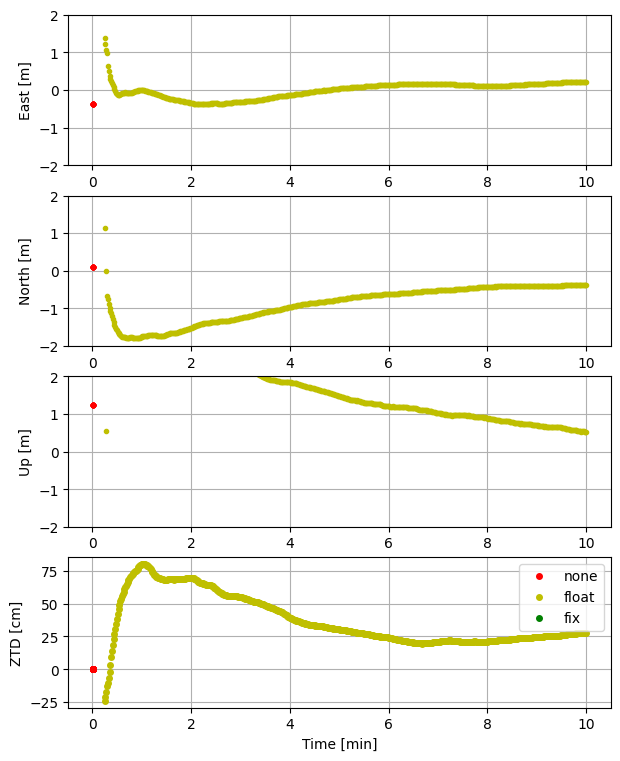

In [140]:
ylim = 2.0
idx4 = np.where(smode == 4)[0]
idx5 = np.where(smode == 5)[0]
idx0 = np.where(smode == 0)[0]

fig = plt.figure(figsize=[7, 9])
fig.set_rasterized(True)
lbl_t = ['East [m]', 'North [m]', 'Up [m]']

for k in range(3):
    plt.subplot(4, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.')
    plt.plot(t[idx5], enu[idx5, k], 'y.')
    plt.plot(t[idx4], enu[idx4, k], 'g.')

    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.ylim([-ylim, ylim])

plt.subplot(4, 1, 4)
plt.plot(t[idx0], ztd[idx0]*1e2, 'r.', markersize=8, label='none')
plt.plot(t[idx5], ztd[idx5]*1e2, 'y.', markersize=8, label='float')
plt.plot(t[idx4], ztd[idx4]*1e2, 'g.', markersize=8, label='fix')

plt.ylabel('ZTD [cm]')
plt.grid()
plt.xlabel('Time [min]')
plt.legend()



## Example 8: PPP positioning (Galileo HAS)

This section shows PPP-RTK positioning using QZSS CLAS.  First, the required Python modules are loaded.

In [141]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from binascii import unhexlify
import bitstruct as bs
from sys import stdout

import cssrlib.gnss as gn
from cssrlib.gnss import ecef2pos, Nav
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.gnss import rSigRnx
from cssrlib.gnss import sys2str
from cssrlib.peph import atxdec, searchpcv
from cssrlib.peph import peph
from cssrlib.cssr_has import cssr_has
from cssrlib.pppssr import rtkinit, ppppos, IT
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [143]:
# Start epoch and number of epochs
ep = [2023, 8, 11, 21, 0, 0]
time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

obsfile = 'cssrlib-data/data/doy223/SEPT223Y.23O'  # PolaRX5'
navfile = 'cssrlib-data/data/doy223/NAV223.23p'

# Specify Galile HAS corrections files
file_has = 'cssrlib-data/data/doy223/223v_gale6.txt'
file_gm = "cssrlib-data/samples/Galileo-HAS-SIS-ICD_1.0_Annex_B_Reed_Solomon_Generator_Matrix.txt"

dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S124')]

# Set user reference position
xyz_ref = [-3962108.6726, 3381309.4719, 3668678.6264]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC7Q"),
        rSigRnx("EL1C"), rSigRnx("EL7Q"),
        rSigRnx("ES1C"), rSigRnx("ES7Q")]

atxfile = 'cssrlib-data/data/igs14.atx'

Load and parse the input data

In [144]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_has, dtype=dtype)
gMat = np.genfromtxt(file_gm, dtype="u1", delimiter=",")

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

cs = cssr_has('has.log')
nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rtkinit(nav, rnx.pos, 'ppphas.log')

    # Modify default config parameters
    nav.elmin = np.deg2rad(5.0)  # min sat el

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available satellite and selected signals

In [145]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C1W S1W C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L
GALILEO C1C L1C D1C S1C C6C L6C D6C S6C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q
SBAS    C1C L1C D1C S1C C5I L5I D5I S5I
GLONASS C1C L1C D1C S1C C1P L1P D1P S1P C2P L2P D2P S2P C2C L2C D2C S2C C3Q L3Q D3Q S3Q
BEIDOU  C1P L1P D1P S1P C5P L5P D5P S5P C2I L2I D2I S2I C7I L7I D7I S7I C6I L6I D6I S6I C7D L7D D7D S7D
QZSS    C1C L1C D1C S1C C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L C1Z L1Z D1Z S1Z C5P L5P D5P S5P
IRNSS   C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C7Q L1C L7Q S1C S7Q 


Process data for 10 minutes (ok to abort before finished)

In [146]:
nep = 10 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Init variables
mid_, ms_, icnt = -1, -1, 0
rec, mid_decoded = [], []
has_pages = np.zeros((255, 53), dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 3600 * 3600

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time // 30 * 30
        nav.time_p = t0

    vi = v[v['tow'] == tow]
    for vn in vi:
        buff = unhexlify(vn['nav'])
        i = 14
        if bs.unpack_from('u24', buff, i)[0] == 0xaf3bc3:
            continue
        hass, res = bs.unpack_from('u2u2', buff, i)
        i += 4
        if hass >= 2:  # 0:test,1:operational,2:res,3:dnu
            continue
        mt, mid, ms, pid = bs.unpack_from('u2u5u5u8', buff, i)

        cs.msgtype = mt
        ms += 1
        i += 20

        if mid_ == -1 and mid not in mid_decoded:
            mid_ = mid
            ms_ = ms
        if mid == mid_ and pid-1 not in rec:
            page = bs.unpack_from('u8'*53, buff, i)
            rec += [pid-1]
            has_pages[pid-1, :] = page

    if len(rec) >= ms_:
        HASmsg = cs.decode_has_page(rec, has_pages, gMat, ms_)
        cs.decode_cssr(HASmsg)
        rec = []

        mid_decoded += [mid_]
        mid_ = -1
        if len(mid_decoded) > 10:
            mid_decoded = mid_decoded[1:]
    else:
        icnt += 1
        if icnt > 2*ms_ and mid_ != -1:
            icnt = 0
            rec = []
            mid_ = -1

    # Call PPP module with HAS corrections
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppppos(nav, obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 60

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[IT(nav.na)] if nav.smode == 4 else nav.x[IT(nav.na)]
    smode[ne] = nav.smode

    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()


 2023-08-11 21:10:00 ENU  -0.007  -0.312   0.322, 2D  0.312, mode 5

Plot results

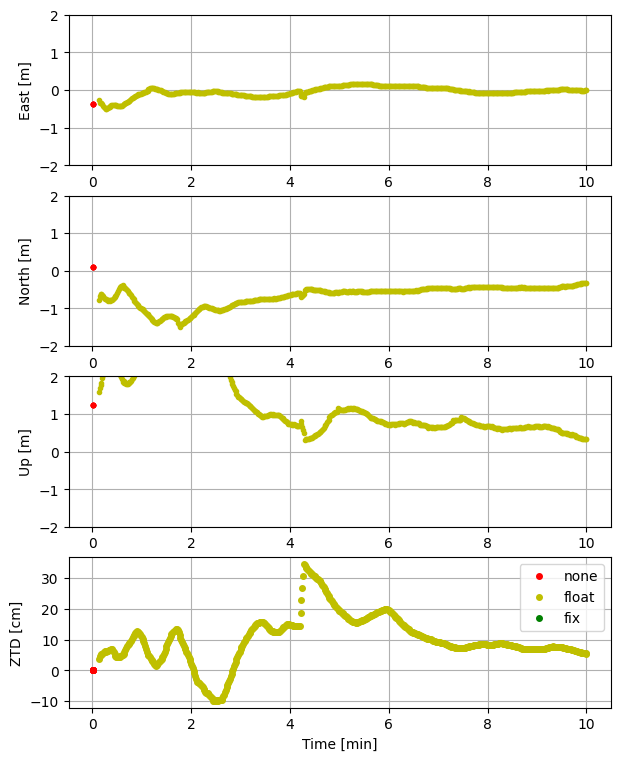

In [147]:
ylim = 2.0

idx4 = np.where(smode == 4)[0]
idx5 = np.where(smode == 5)[0]
idx0 = np.where(smode == 0)[0]

fig = plt.figure(figsize=[7, 9])
fig.set_rasterized(True)


lbl_t = ['East [m]', 'North [m]', 'Up [m]']
#x_ticks = np.arange(0, nep/60+1, step=1)

for k in range(3):
    plt.subplot(4, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.')
    plt.plot(t[idx5], enu[idx5, k], 'y.')
    plt.plot(t[idx4], enu[idx4, k], 'g.')

    # plt.xticks(x_ticks)
    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.ylim([-ylim, ylim])
    # plt.axis([0, ne, -ylim, ylim])

plt.subplot(4, 1, 4)
plt.plot(t[idx0], ztd[idx0]*1e2, 'r.', markersize=8, label='none')
plt.plot(t[idx5], ztd[idx5]*1e2, 'y.', markersize=8, label='float')
plt.plot(t[idx4], ztd[idx4]*1e2, 'g.', markersize=8, label='fix')

plt.ylabel('ZTD [cm]')
plt.grid()
plt.xlabel('Time [min]')
plt.legend()



## Example 9: PPP positioning (MADOCA)

This section shows PPP positioning using MADOCA. First, the required Python modules are loaded.

In [148]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from binascii import unhexlify
from sys import stdout

import cssrlib.gnss as gn
from cssrlib.gnss import ecef2pos, Nav
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.gnss import rSigRnx
from cssrlib.gnss import sys2str
from cssrlib.peph import atxdec, searchpcv
from cssrlib.cssrlib import cssr
from cssrlib.cssrlib import sCSSRTYPE as sc
from cssrlib.pppssr import rtkinit, ppppos, IT
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [149]:
# Start epoch and number of epochs
ep = [2023, 8, 11, 21, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

obsfile = 'cssrlib-data/data/doy223/SEPT223Y.23O'
navfile = 'cssrlib-data/data/doy223/NAV223.23p'

# Specify L6 corrections files
file_l6 = 'cssrlib-data/data/doy223/223v_qzsl6.txt'
prn_ref = 199  # QZSS PRN
l6_ch = 1  # 0:L6D, 1:L6E
dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S500')]

# Set user reference position
xyz_ref = [-3962108.6726, 3381309.4719, 3668678.6264]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]

atxfile = 'cssrlib-data/data/igs20.atx'

Load and parse the input data

In [150]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_l6, dtype=dtype)

cs = cssr('madoca_cssr.log')
cssrmode = sc.QZS_MADOCA
cs.monlevel = 0

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rr = rnx.pos
    pos = ecef2pos(rr)
    rtkinit(nav, rnx.pos,'pppmdc.log')

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available satellite signals

In [151]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C1W S1W C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L
GALILEO C1C L1C D1C S1C C6C L6C D6C S6C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q
SBAS    C1C L1C D1C S1C C5I L5I D5I S5I
GLONASS C1C L1C D1C S1C C1P L1P D1P S1P C2P L2P D2P S2P C2C L2C D2C S2C C3Q L3Q D3Q S3Q
BEIDOU  C1P L1P D1P S1P C5P L5P D5P S5P C2I L2I D2I S2I C7I L7I D7I S7I C6I L6I D6I S6I C7D L7D D7D S7D
QZSS    C1C L1C D1C S1C C2L L2L D2L S2L C5Q L5Q D5Q S5Q C1L L1L D1L S1L C1Z L1Z D1Z S1Z C5P L5P D5P S5P
IRNSS   C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 
QZSS    C1C C2L L1C L2L S1C S2L 


Process data for 10 minutes (ok to abort before finished)

In [152]:
nep = 10 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 3600*3600

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        nav.time_p = t0

    vi = v[(v['tow'] == tow) & (v['type'] == l6_ch)
           & (v['prn'] == prn_ref)]
    if len(vi) > 0:
      msg = unhexlify(vi['nav'][0])
      cs.decode_l6msg(msg, 0)
      if cs.fcnt == 5:  # end of sub-frame
          cs.decode_cssr(cs.buff, 0)

    # Call PPP module
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppppos(nav, obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 60
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    ztd[ne] = nav.xa[IT(nav.na)] if nav.smode == 4 else nav.x[IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

 2023-08-11 21:10:00 ENU   0.128   0.213   0.144, 2D  0.248, mode 5

Plot results

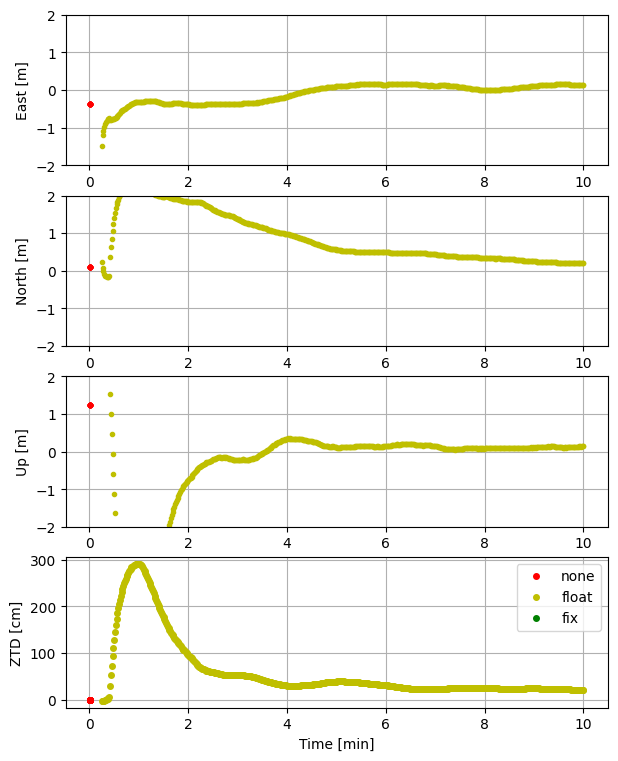

In [153]:
ylim = 2.0

idx4 = np.where(smode == 4)[0]
idx5 = np.where(smode == 5)[0]
idx0 = np.where(smode == 0)[0]

fig = plt.figure(figsize=[7, 9])
fig.set_rasterized(True)
lbl_t = ['East [m]', 'North [m]', 'Up [m]']

for k in range(3):
    plt.subplot(4, 1, k+1)
    plt.plot(t[idx0], enu[idx0, k], 'r.')
    plt.plot(t[idx5], enu[idx5, k], 'y.')
    plt.plot(t[idx4], enu[idx4, k], 'g.')

    plt.ylabel(lbl_t[k])
    plt.grid()
    plt.ylim([-ylim, ylim])

plt.subplot(4, 1, 4)
plt.plot(t[idx0], ztd[idx0]*1e2, 'r.', markersize=8, label='none')
plt.plot(t[idx5], ztd[idx5]*1e2, 'y.', markersize=8, label='float')
plt.plot(t[idx4], ztd[idx4]*1e2, 'g.', markersize=8, label='fix')

plt.ylabel('ZTD [cm]')
plt.grid()
plt.xlabel('Time [min]')
plt.legend()


## Reference

- [1] T. Takasu, “RTKLIB: Open Source Program Package for RTK-GPS,” FOSS4G 2009 Tokyo, Japan, 2009.